In [2]:
# importar bibliotecas
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

In [3]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [4]:
consulta_sql = """
 select
  y.dt_obito,
  m.nm_regiao,
  m.sl_uf,
  m.nm_municipio,
  p.populacao,
  y.yll
 from `ml-na-saude.yll_por_obito.yll` y
 join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
 join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
 where p.porte = 'Médio Porte'
"""

In [5]:
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [6]:
df.head()

,dt_obito,nm_regiao,sl_uf,nm_municipio,populacao,yll
0,2010-07-08,Norte,AC,Cruzeiro do Sul,78444,82.58
1,2012-08-17,Norte,AC,Cruzeiro do Sul,79819,77.58
2,2012-02-27,Norte,AC,Cruzeiro do Sul,79819,89.07
3,2016-09-12,Norte,AC,Cruzeiro do Sul,82075,67.62
4,2019-10-11,Norte,AC,Cruzeiro do Sul,88376,67.62


In [66]:
df_tratado = df

In [67]:
# Função para obter o primeiro dia do primeiro mês do quadrimestre
def quadrimestre_obto(data):
    mes = data.month
    if mes in [1, 2, 3, 4]:
        return pd.Timestamp(f'{data.year}-01-01')  # Janeiro
    elif mes in [5, 6, 7, 8]:
        return pd.Timestamp(f'{data.year}-05-01')  # Maio
    elif mes in [9, 10, 11, 12]:
        return pd.Timestamp(f'{data.year}-09-01')  # Setembro

# Aplicando a função para criar a nova coluna 'quadrimestre'
df_tratado['quadrimestre'] = df_tratado['dt_obito'].apply(quadrimestre_obto)

In [68]:
df_tratado['taxa_yll'] = df_tratado['yll'] * 1000 / df_tratado['populacao']

In [69]:
df_tratado.head()

,dt_obito,nm_regiao,sl_uf,nm_municipio,populacao,yll,quadrimestre,taxa_yll
0,2010-07-08,Norte,AC,Cruzeiro do Sul,78444,82.58,2010-05-01,1.052726
1,2012-08-17,Norte,AC,Cruzeiro do Sul,79819,77.58,2012-05-01,0.971949
2,2012-02-27,Norte,AC,Cruzeiro do Sul,79819,89.07,2012-01-01,1.1159
3,2016-09-12,Norte,AC,Cruzeiro do Sul,82075,67.62,2016-09-01,0.823881
4,2019-10-11,Norte,AC,Cruzeiro do Sul,88376,67.62,2019-09-01,0.76514


In [70]:
df_tratado['quadrimestre'] = pd.to_datetime(df_tratado['quadrimestre'])

In [71]:
df_tratado = df_tratado.set_index('quadrimestre')

In [72]:
time_series = df_tratado.resample('4MS').agg({'taxa_yll': 'mean'})

In [73]:
time_series.head()

,taxa_yll
quadrimestre,
2010-01-01,0.320693
2010-05-01,0.315388
2010-09-01,0.313191
2011-01-01,0.307777
2011-05-01,0.305335


In [75]:
time_series

,taxa_yll
quadrimestre,
2010-01-01,0.320693
2010-05-01,0.315388
2010-09-01,0.313191
2011-01-01,0.307777
2011-05-01,0.305335
2011-09-01,0.305019
2012-01-01,0.304178
2012-05-01,0.304277
2012-09-01,0.301382


In [76]:
time_series.describe()

,taxa_yll
count,30.0
mean,0.29709
std,0.009453
min,0.284684
25%,0.289458
50%,0.296
75%,0.303708
max,0.320693


Text(0.5, 1.0, 'Taxa do YLL')

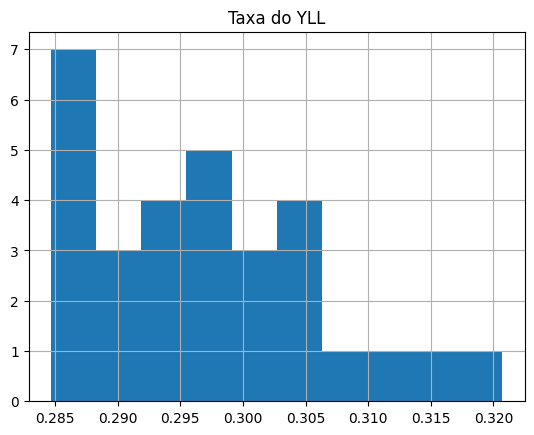

In [78]:
time_series.hist()
plt.title('Taxa do YLL')

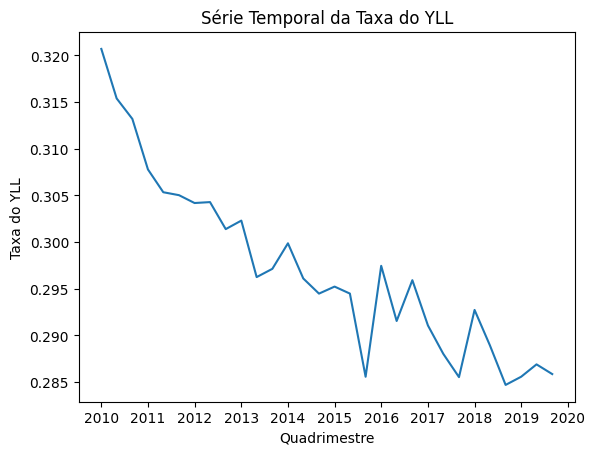

In [79]:
plt.plot(time_series)
plt.title('Série Temporal da Taxa do YLL')
plt.xlabel('Quadrimestre')
plt.ylabel('Taxa do YLL')
plt.show()

In [80]:
# # Configura o eixo x como quadrimestre_obto e o eixo y como taxa_yll
# plt.plot(df['quadrimestre'], df['taxa_yll'], marker='o')
# plt.title('Taxa do YLL por Quadrimestre')
# plt.xlabel('Quadrimestre')
# plt.ylabel('Taxa do YLL')
# plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização
# plt.tight_layout()  # Ajusta o layout para evitar sobreposição
# plt.show()

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(time_series, model='aditive')

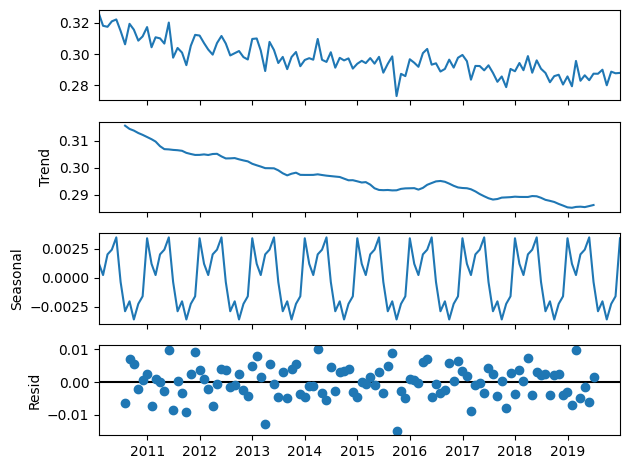

In [82]:
result.plot()
plt.show()

In [82]:
from statsmodels.tsa.stattools import adfuller

### Teste de Estacionaridade

In [83]:
def teste_adf(serie):
    result = adfuller(serie)
    print('ADF Estatíticas: %f' % result[0])
    print('Valor de P: %f' % result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

In [84]:
# Executa o teste de estacionaridade em 'taxa_yll'
teste_adf(time_series['taxa_yll'])

ADF Estatíticas: -2.413426
Valor de P: 0.137983
Valores Críticos:
	1%: -3.738
	5%: -2.992
	10%: -2.636
A série não é estacionária.


### Tornando a série estacionária (Diferenciação)

In [85]:
# Diferenciação simples
time_series['taxa_yll_diff'] = time_series['taxa_yll'].diff().dropna()

# Verifica novamente a estacionaridade após a diferenciação
teste_adf(time_series['taxa_yll_diff'].dropna())

ADF Estatíticas: -3.938173
Valor de P: 0.001771
Valores Críticos:
	1%: -3.738
	5%: -2.992
	10%: -2.636
A série é estacionária.


<Axes: xlabel='quadrimestre'>

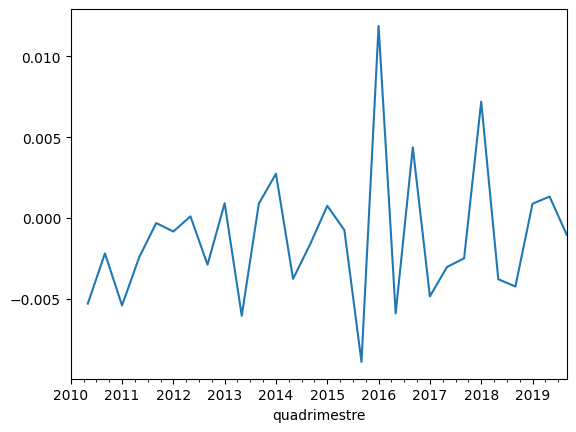

In [86]:
xlabel='Data'
time_series['taxa_yll_diff'].plot()

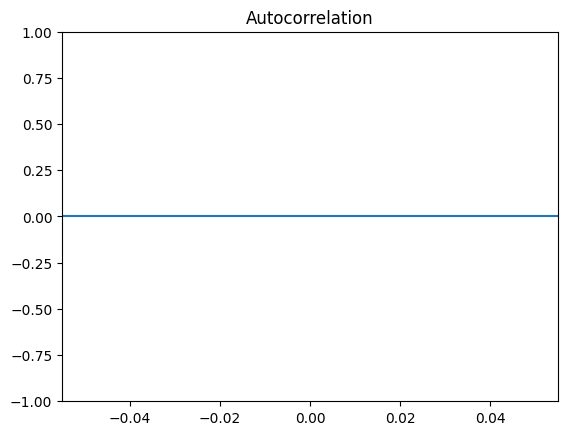

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(time_series['taxa_yll_diff'])
plt.show()